In [1]:
# Weird precipitation maps... stripes

In [15]:
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import gc
import xarray as xr
import pandas as pd
import xrft as xrft
import warnings
import sys
import gsw as gsw
sys.path.append("/homes/metogra/iufarias/FeedbackSubmeso/useful/")
import romspickle
# import seawater as sw

from dask.diagnostics import ProgressBar
import matplotlib.dates as mdates



warnings.filterwarnings("ignore")

In [2]:
# from dask.diagnostics import ProgressBar
# import dask
# # dask.config.set(**{'array.slicing.split_large_chunks': True})
# from dask.distributed import Client, LocalCluster

# # cluster = LocalCluster(n_workers=61)
# # client = Client(cluster)

# # client

In [ ]:
import xesmf as xe
    
def regrid(var, lons, lats, which):
    # rename coords for use with xESMF
    lonkey = [coord for coord in var.coords if "nav_lon" in coord][0]
    latkey = [coord for coord in var.coords if "nav_lat" in coord][0]
    var = var.rename({lonkey: "lon", latkey: "lat"})

    # whether inputs are
    if which == "pairs":
        locstream_out = True
    elif which == "grid":
        locstream_out = False

    # set up for output
    varint = xr.Dataset({"lat": (["y", "x"], lats), "lon": (["y", "x"], lons)})

    # Calculate weights.
    regridder = xe.Regridder(var, varint, "bilinear",  locstream_out=locstream_out)

    # Perform interpolation
    varint = regridder(var, keep_attrs=True)
    return varint, regridder



In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Lucida Grande']

In [ ]:
dxx=0.5

In [ ]:
chunks_new={'time_counter':10}

path='/data/pacific/lrenault/SASI/CROCO/FULL/'
listm=glob(path+'surf*.nc');listm.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varf=xr.open_mfdataset(listm[1:],data_vars='minimal',chunks=chunks_new)

path='/data/pacific/lrenault/SASI/CROCO/SMTH/'
listt=glob(path+'surf*SASI_6h_his_20*_*.nc');listt.sort()
listt.append('/data/pacific/lrenault/SASI/CROCO/SMTH/surf_SASI_6h_his_2012-07.nc')
#vart=xr.open_dataset(listt[xmon])
vart=xr.open_mfdataset(listt[1:],data_vars='minimal',chunks=chunks_new)

In [ ]:

path='/data/pacific/lrenault/SASI/FULL/WRF/'
listmw=glob(path+'wrf_*.nc');listmw.sort()
# varf=xr.open_dataset(listm[-9:][xmon])
varfw=xr.open_mfdataset(listmw[::2][-7:],chunks=chunks_new)

path='/data/pacific/lrenault/SASI/SMTH/WRF/'
listtw=glob(path+'wrf_*.nc');listtw.sort()
#vart=xr.open_dataset(listt[xmon])
vartw=xr.open_mfdataset(listtw[::2][-7:],chunks=chunks_new)

In [ ]:
listtw[::2][-7:]

['/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M01.nc',
 '/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M02.nc',
 '/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M03.nc',
 '/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M04.nc',
 '/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M05.nc',
 '/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M06.nc',
 '/data/pacific/lrenault/SASI/SMTH/WRF/wrf_3D_Y2012M07.nc']

In [ ]:

# path='/data/pacific/lrenault/SASI/FULL/WRF/'
# listmw2=glob(path+'wrf_*DAY*.nc');listmw2.sort()
# # varf=xr.open_dataset(listm[-9:][xmon])
# varfw2=xr.open_mfdataset(listmw2[-7:],chunks=chunks_new)

In [ ]:
varfw.coords['2htime']=varfw.time_counter.dt.floor('2H')
vartw.coords['2htime']=vartw.time_counter.dt.floor('2H')

# Precipitation & Latent Heat

In [11]:
%%time
# chunks_new={'time_counter':40}
lh_full=varfw.LH.groupby('2htime').mean()[:,30:-30,30:-90].compute()
lh_smth=vartw.LH.groupby('2htime').mean()[:,30:-30,30:-90].compute()

P_full=varfw.RAIN.groupby('2htime').mean()[:,30:-30,30:-90].compute()/12
P_smth=vartw.RAIN.groupby('2htime').mean()[:,30:-30,30:-90].compute()/12

CPU times: user 30.7 s, sys: 7.37 s, total: 38 s
Wall time: 4min 27s


In [78]:
P_full1h=varfw.RAIN[:,30:-30,30:-90].compute()/12
P_smth1h=vartw.RAIN[:,30:-30,30:-90].compute()/12

In [12]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'

In [13]:
%%time
with ProgressBar():
    Precip_full_spec=xrft.isotropic_power_spectrum(P_full.drop(['nav_lat','nav_lon']),dim=['y','x'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).compute()
    Precip_smth_spec=xrft.isotropic_power_spectrum(P_smth.drop(['nav_lat','nav_lon']),dim=['y','x'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).compute()

CPU times: user 11min 29s, sys: 38min 30s, total: 49min 59s
Wall time: 52.2 s


In [35]:
%%time
with ProgressBar():
    LH_full_spec=xrft.isotropic_power_spectrum(lh_full.drop(['nav_lat','nav_lon']),dim=['y','x'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).compute()
    LH_smth_spec=xrft.isotropic_power_spectrum(lh_smth.drop(['nav_lat','nav_lon']),dim=['y','x'],
                              nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                     window=wdws,window_correction=wdw_cor).compute()

CPU times: user 9min 8s, sys: 24min 27s, total: 33min 36s
Wall time: 43.1 s


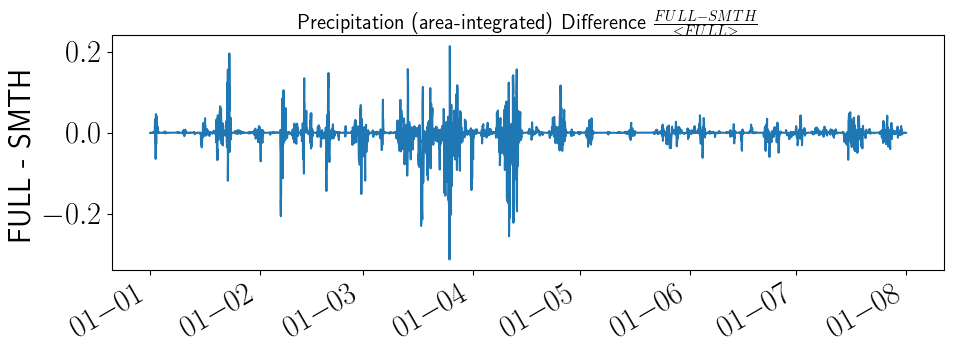

In [103]:
plt.figure(figsize=(10,4))

# plt.plot(P_full['2htime'],P_full.sum(['x','y']),alpha=0.5)
# plt.plot(P_smth['2htime'],P_smth.sum(['x','y']),alpha=0.5)
plt.plot(P_smth['2htime'],(P_full.sum(['x','y'])-P_smth.sum(['x','y']))/(P_smth.sum(['x','y']).mean()),alpha=1)


plt.title(r'Precipitation (area-integrated) Difference $\frac{FULL - SMTH}{<FULL>}$',fontsize=15)
plt.ylabel(r'FULL - SMTH ')
# plt.ylim(-3,3)
# ((P_full.sum(['x','y'])-P_smth.sum(['x','y']))/((P_full.sum(['x','y'])+P_smth.sum(['x','y'])).mean()/2)).plot()
# plt.ylim(-0.4,0.4)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
plt.gcf().autofmt_xdate() # Rotation
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/random_spectra/Precip_2h_diff_ratio.png')



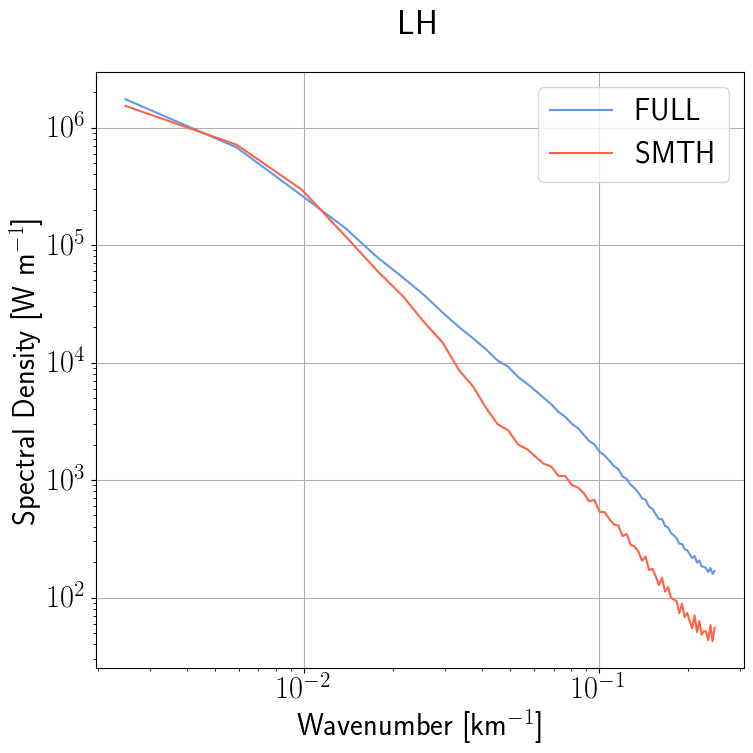

In [36]:
plt.figure(figsize=(8,8))

plt.plot(LH_full_spec.freq_r/2,LH_full_spec.mean(axis=0)/2*1000,label='FULL',color='cornflowerblue')
plt.plot(LH_smth_spec.freq_r/2,LH_smth_spec.mean(axis=0)/2*1000,label='SMTH',color='tomato')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.title(r'LH ',fontsize=25,y=1.05)

plt.ylabel(r'Spectral Density [W m$^{-1}$]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


# plt.xlim(1e-2,0)
# plt.ylim(0.5e-12,3e-9)
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/random_spectra/LH_spectra_mean.png')



In [12]:
%%time
# chunks_new={'time_counter':40}
sst_full=varfw.SST.groupby('2htime').mean()[:,30:-30,30:-90].compute()
sst_smth=vartw.SST.groupby('2htime').mean()[:,30:-30,30:-90].compute()


CPU times: user 29.3 s, sys: 3.96 s, total: 33.3 s
Wall time: 24.3 s


In [13]:
nf=2
wdws='hann' #'flattop','hann'
wdw_cor=True
scl='density'
trunc='False'

In [14]:
%%time
SST_full_spec_2=xrft.isotropic_power_spectrum(sst_full.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate=trunc,scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()
SST_smth_spec_2=xrft.isotropic_power_spectrum(sst_smth.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate=trunc,scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()

CPU times: user 8min 9s, sys: 24min 47s, total: 32min 57s
Wall time: 43.8 s


In [37]:
nf=4

In [38]:
%%time
SST_full_spec_4=xrft.isotropic_power_spectrum(sst_full.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()
SST_smth_spec_4=xrft.isotropic_power_spectrum(sst_smth.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()

CPU times: user 9min 49s, sys: 28min 43s, total: 38min 32s
Wall time: 45.2 s


In [39]:
nf=8

In [40]:
%%time
SST_full_spec_8=xrft.isotropic_power_spectrum(sst_full.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()
SST_smth_spec_8=xrft.isotropic_power_spectrum(sst_smth.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate='True',scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()

CPU times: user 10min 14s, sys: 30min 18s, total: 40min 33s
Wall time: 46.3 s


# Differences

In [41]:
diff_SST_spectra_2=(SST_full_spec_2-SST_smth_spec_2)
diff_SST_spectra_4=(SST_full_spec_4-SST_smth_spec_4)
diff_SST_spectra_8=(SST_full_spec_8-SST_smth_spec_8)

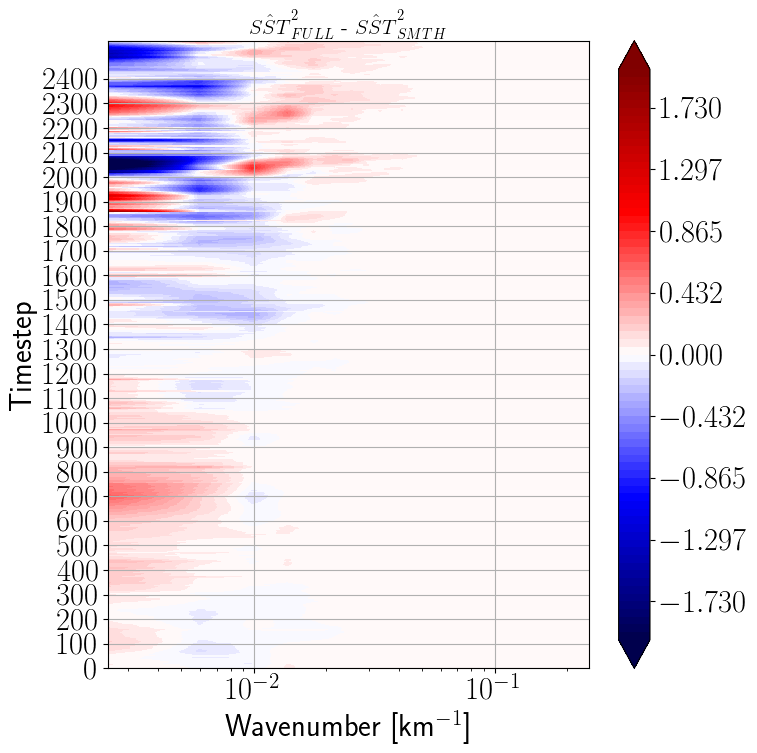

In [52]:
plt.figure(figsize=(8,8))

# plt.contourf(diff_SST_spectra_2.freq_r/2,pd.DatetimeIndex(diff_SST_spectra_2['2htime']),diff_SST_spectra_2/2,
#              cmap='seismic',levels=np.linspace(-2,2,75),extend='both')


plt.contourf(diff_SST_spectra_2.freq_r/2,np.arange(len(diff_SST_spectra_2['2htime'])),diff_SST_spectra_2/2,
             cmap='seismic',levels=np.linspace(-2,2,75),extend='both')

# plt.legend()
plt.xscale('log')
# plt.yscale('log')
plt.title(r' $\hat{SST}^2_{FULL}$ - $\hat{SST}^2_{SMTH}$',fontsize=15)
plt.ylabel(r'Timestep',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
plt.colorbar()
plt.yticks(np.arange(0,2500,100))
# plt.xlim(1e-2,0)
# plt.ylim(2000,2100)
plt.grid()
plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/random_spectra/diff_SST_spectra_hovmoller.png')



# plt.figure(figsize=(8,8))

# plt.contourf(diff_SST_spectra_4.freq_r/2,pd.DatetimeIndex(diff_SST_spectra_4['2htime']),diff_SST_spectra_4/2,
#              cmap='seismic',levels=np.linspace(-1,1,75),extend='both')

# # plt.legend()
# plt.xscale('log')
# # plt.yscale('log')
# plt.title(r' $\hat{SST}^2_{FULL}$ - $\hat{SST}^2_{SMTH}$',fontsize=15)
# plt.ylabel(r'Timestep',fontweight='bold')
# plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.colorbar()

# # plt.xlim(1e-2,0)
# # plt.ylim(2000,2100)
# plt.grid()
# plt.tight_layout()
# plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/random_spectra/diff_SST_spectra_hovmoller_4bins.png')




# plt.figure(figsize=(8,8))

# plt.contourf(diff_SST_spectra_8.freq_r/2,np.arange(len(diff_SST_spectra_8['2htime'])),diff_SST_spectra_8/2,
#              cmap='seismic',levels=np.linspace(-1,1,75),extend='both')
# # plt.legend()
# plt.xscale('log')
# # plt.yscale('log')
# plt.title(r' $\hat{SST}^2_{FULL}$ - $\hat{SST}^2_{SMTH}$',fontsize=15)
# plt.ylabel(r'Timestep',fontweight='bold')
# plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')
# plt.colorbar()

# plt.xlim(1e-2,0)
# # plt.ylim(2000,2100)
# plt.grid()
# plt.tight_layout()

# Average

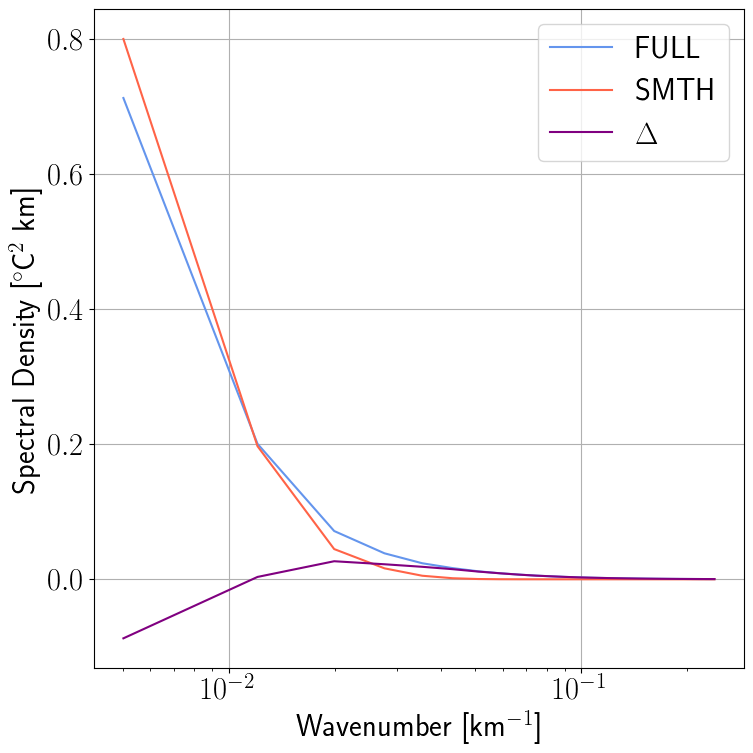

In [48]:
plt.figure(figsize=(8,8))

# plt.plot(SST_full_spec_2.freq_r/2,SST_full_spec_2.mean(axis=0)/2,label='FULL',color='cornflowerblue')
plt.plot(SST_full_spec_4.freq_r/2,SST_full_spec_4.mean(axis=0)/2,linestyle='-',label='FULL',color='cornflowerblue')
# plt.plot(SST_full_spec_8.freq_r/2,SST_full_spec_8.mean(axis=0)/2*1000,marker='o',label='FULL',color='cornflowerblue')

# plt.plot(SST_smth_spec_2.freq_r/2,SST_smth_spec_2.mean(axis=0)/2,label='SMTH',color='tomato')
plt.plot(SST_smth_spec_4.freq_r/2,SST_smth_spec_4.mean(axis=0)/2,linestyle='-',label='SMTH',color='tomato')
# plt.plot(SST_smth_spec_8.freq_r/2,SST_smth_spec_8.mean(axis=0)/2,marker='o',label='SMTH',color='tomato')

# plt.plot(SST_smth_spec_2.freq_r/2,diff_SST_spectra_2.mean(axis=0)/2,label=r'$\Delta$',color='purple')
plt.plot(SST_smth_spec_4.freq_r/2,diff_SST_spectra_4.mean(axis=0)/2,label=r'$\Delta$',color='purple')




plt.legend()
plt.xscale('log')
# plt.yscale('log')

plt.ylabel(r'Spectral Density [$^{\circ}$C$^{2}$ km]',fontweight='bold')
plt.xlabel(r'Wavenumber  [km$^{-1}$]',fontweight='bold')


# plt.xlim(1e-2,0)
# plt.ylim(0.5e-12,3e-9)
plt.grid()
plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/random_spectra/overall_difference.png')



# Timestep

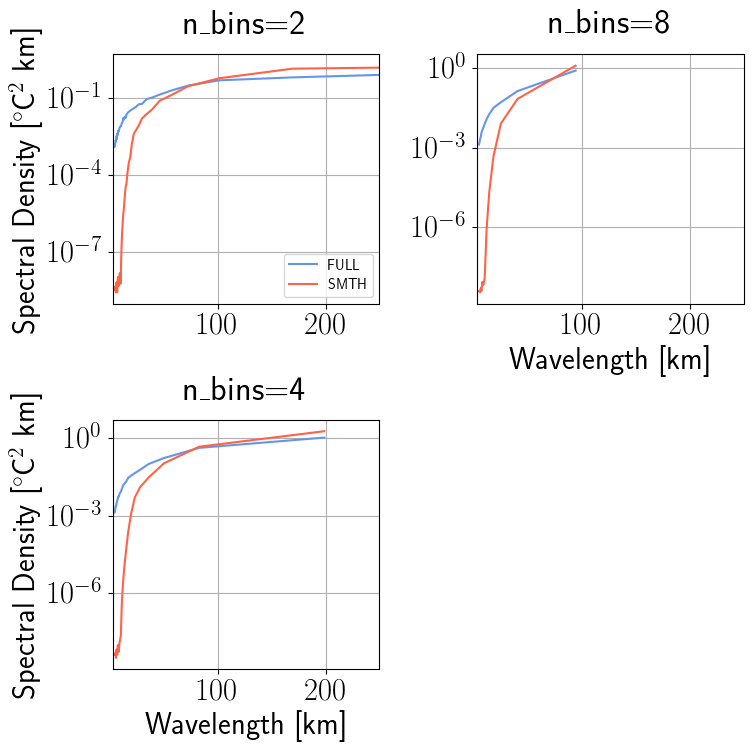

In [58]:
iddx=2380

plt.figure(figsize=(8,8))
plt.subplot(2,2,1)

plt.plot(1/(SST_full_spec_2.freq_r/2),SST_full_spec_2[iddx]/2,label='FULL',color='cornflowerblue')
plt.plot(1/(SST_full_spec_2.freq_r/2),SST_smth_spec_2[iddx]/2,label='SMTH',color='tomato')
# plt.plot(1/(SST_full_spec_2.freq_r/2),diff_SST_spectra_2[iddx]/2,label=r'$\Delta$',color='purple')
plt.xlim(2.5,250)
# plt.ylim(1e-10,1)




plt.legend(fontsize=10)
# plt.xscale('log')
plt.yscale('log')


plt.title(r'n_bins=2 ',fontsize=25,y=1.05)
plt.ylabel(r'Spectral Density [$^{\circ}$C$^2$ km]',fontweight='bold')

# plt.xlabel(r'Wavelength  [km]',fontweight='bold')

plt.grid()
# plt.yscale('symlog')



plt.subplot(2,2,3)

plt.plot(1/(SST_full_spec_4.freq_r/2),SST_full_spec_4[iddx]/2,label='FULL',color='cornflowerblue')
plt.plot(1/(SST_smth_spec_4.freq_r/2),SST_smth_spec_4[iddx]/2,label='SMTH',color='tomato')
# plt.plot(1/(SST_full_spec_4.freq_r/2),diff_SST_spectra_4[iddx]/2*1000,label=r'$\Delta$',color='purple')
plt.xlim(2.5,250)
# plt.ylim(1e-10,1)



# plt.xscale('log')
plt.yscale('log')
plt.title(r'n_bins=4 ',fontsize=25,y=1.05)
plt.ylabel(r'Spectral Density [$^{\circ}$C$^2$ km]',fontweight='bold')

plt.xlabel(r'Wavelength  [km]',fontweight='bold')
plt.grid()




plt.subplot(2,2,2)
plt.plot(1/(SST_full_spec_8.freq_r/2),SST_full_spec_8[iddx]/2,linestyle='-',label='FULL',color='cornflowerblue')
plt.plot(1/(SST_smth_spec_8.freq_r/2),SST_smth_spec_8[iddx]/2,linestyle='-',label='SMTH',color='tomato')
# plt.plot(1/(SST_full_spec_8.freq_r/2),diff_SST_spectra_8[iddx]/2*1000,label=r'$\Delta$',color='purple')

plt.xlim(2.5,250)
# plt.ylim(1e-10,1)


# plt.xscale('log')
plt.yscale('log')
plt.title(r'n_bins=8 ',fontsize=25,y=1.05)
# plt.ylabel(r'Spectral Density [$^{\circ}$C$^2$ km]',fontweight='bold')

plt.xlabel(r'Wavelength  [km]',fontweight='bold')

plt.grid()


plt.tight_layout()

plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/random_spectra/bin_difference_spectra_timestep_{0}_2.png'.format(iddx))
# 




# Space crop analysis

In [21]:

sst_full_B=varfw.SST.groupby('2htime').mean()[:,60:-60,60:-90].compute()
sst_smth_B=vartw.SST.groupby('2htime').mean()[:,60:-60,60:-90].compute()



In [22]:
%%time
SST_full_spec_2b=xrft.isotropic_power_spectrum(sst_full_B.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate=trunc,scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()
SST_smth_spec_2b=xrft.isotropic_power_spectrum(sst_smth_B.drop(['nav_lat','nav_lon']),dim=['y','x'],
                          nfactor=nf,truncate=trunc,scaling=scl,detrend='linear', 
                                 window=wdws,window_correction=wdw_cor).compute()

CPU times: user 7min 24s, sys: 19min 36s, total: 27min
Wall time: 32.1 s


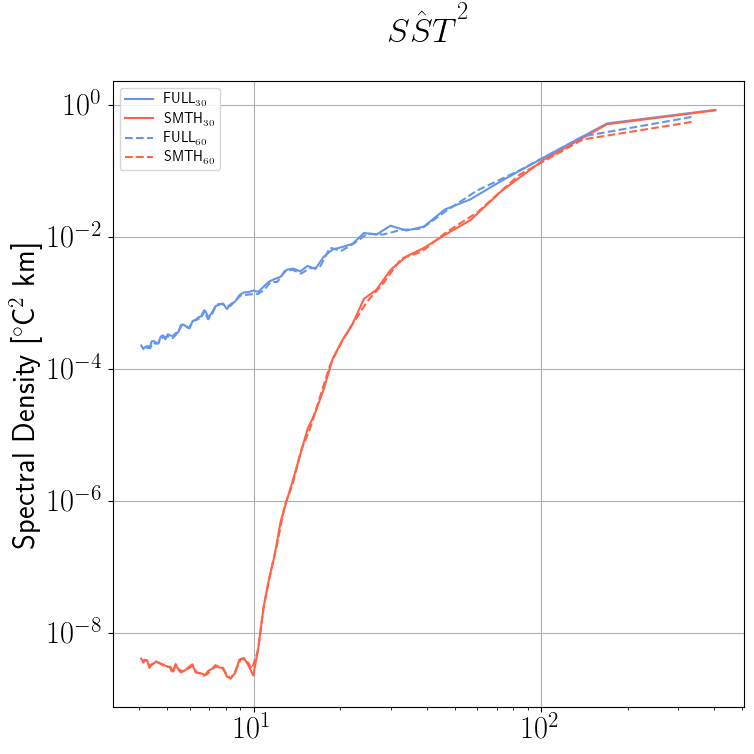

In [29]:
iddx=0

plt.figure(figsize=(8,8))

plt.plot(1/(SST_full_spec_2.freq_r/2),SST_full_spec_2[iddx]/2,label=r'FULL$_{30}$',color='cornflowerblue')
plt.plot(1/(SST_full_spec_2.freq_r/2),SST_smth_spec_2[iddx]/2,label=r'SMTH$_{30}$',color='tomato')

plt.plot(1/(SST_full_spec_2b.freq_r/2),SST_full_spec_2b[iddx]/2,label=r'FULL$_{60}$',linestyle='--',color='cornflowerblue')
plt.plot(1/(SST_full_spec_2b.freq_r/2),SST_smth_spec_2b[iddx]/2,label=r'SMTH$_{60}$',linestyle='--',color='tomato')



# plt.xlim(2.5,250)
# plt.ylim(1e-10,1)




plt.legend(fontsize=10)
plt.xscale('log')
plt.yscale('log')


plt.title(r'$\hat{SST}^2$ ',fontsize=25,y=1.05)
plt.ylabel(r'Spectral Density [$^{\circ}$C$^2$ km]',fontweight='bold')

# plt.xlabel(r'Wavelength  [km]',fontweight='bold')

plt.grid()
# plt.yscale('symlog')

plt.tight_layout()
plt.savefig('/homes/metogra/iufarias/Documents/figures/2_CROCO/random_spectra/SST_spectra_different_crops.png')

